<font size = "64"> **CIS 5450 Group Project** </font>

---

#Tokyo Stock Market Expected Returns Prediction

###*Divek Patel, Anirudh Bharadwaj, Aryan Roy*




## **Background**
Predicting stock returns through quantitative analysis is a crucial challenge as well as the largest opportunity in the fields of finance and investment. This is because it not only provides methods for model trading programmatically, but generally provides investors with insight on identifying potentially profitable investment opportunities, optimizing their clients’ portfolios and enabling effective risk management worthy of their reputations. Thus, as a necessary tool for ensuring reliability in increasingly volatile markets, many financial institutions have recently turned toward data-driven predictive algorithms and processes to provide more accurate and calculative decisions to determine securities with the largest returns. 

One company in the pursuit of such predictive models is the Japan Exchange Group, Inc. (JPX), one of the largest companies that operates the Tokyo Stock Exchange. Their released data, which we will be using for this project, consists of historical time-series stock trading data in the Japanese market from 2017-2020. This will be especially interesting, as foreign market data is usually restricted for public use, and finding these comprehensive datasets presents an opportunity to inquire further into international markets.






## **Data Description**

The objective of this project is to predict the future returns of each of the stocks, where the target evaluation metric is the rate of change between the closing price two days from the trade date ($C_{k+2}$) and the closing price one day from the trade date  ($C_{k+1}$). In other words, it is the change ratio of adjusted closing price between days $t+2$ and $t+1$,  where day $t+0$ is the date of confirmed trade. 

We define the target change ratio $r_c$ as follows: $$r_c = \frac{(C_{k+2} - C_{k+1})}{C_{k+1}}$$. 

The core file of interest and analysis is “stock_prices.csv”, which contains stock data, such as Open, High, Low, Close, Volume, etc., on the 2,000 most commonly traded equities in Japan’s markets. For additional analysis and comparison, “secondary_stock_prices.csv” records less liquid securities, but is useful in determining a more general distribution of Japanese markets. Additionally, “stock_list.csv” provides additional qualitative information on each stock, specifically details its market sector (17 & 33 sectors) and sections (Prime Market, Standard Market, JASDAQ, ETFs, etc.). 

We will first conduct Exploratory Data Analysis and Feature Selection, followed by Model Selection/Training and interpretation of results. 



## **Part 1: Exploratory Data Analysis**

### 1.0: Import Libraries

We will first import all necessary packages for the EDA, as well as connecting to Google Drive for data extraction. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.1: Instantiate & Prepare Datasets 

In this section, we import the datasets and initially clean the data before subsequent EDA. 

From Google Drive, we will bring all the needed datasets, such as stock_prices.csv (set to main_stocks_df) and stock_list.csv (set to stock_list_df), to the project notebook.

In [3]:
#Instantiate datasets from Google Drive
main_stocks_df = pd.read_csv("drive/MyDrive/CIS545Project/stock_prices.csv")
stock_list_df = pd.read_csv('drive/MyDrive/CIS545Project/stock_list.csv')

Let's look at the layout of main_stocks_df and stock_list_df, such as shape, dtypes, and null entries. 

In [4]:
#Prints the shape layout of main_stocks_df 
print("main_stocks_df shape:", main_stocks_df.shape)
main_stocks_df.info()

main_stocks_df shape: (2332531, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [5]:
#Determines the number of empty entries in every column in main_stocks_df 
main_stocks_nan_count = main_stocks_df.isna().sum()
print(main_stocks_nan_count)

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64


In [6]:
#Prints the shape layout of stock_list_df 
print("stock_list_df shape:", stock_list_df.shape)
stock_list_df.info()

stock_list_df shape: (4417, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SecuritiesCode          4417 non-null   int64  
 1   EffectiveDate           4417 non-null   int64  
 2   Name                    4417 non-null   object 
 3   Section/Products        4417 non-null   object 
 4   NewMarketSegment        3772 non-null   object 
 5   33SectorCode            4417 non-null   object 
 6   33SectorName            4417 non-null   object 
 7   17SectorCode            4417 non-null   object 
 8   17SectorName            4417 non-null   object 
 9   NewIndexSeriesSizeCode  4417 non-null   object 
 10  NewIndexSeriesSize      4417 non-null   object 
 11  TradeDate               4121 non-null   float64
 12  Close                   4121 non-null   float64
 13  IssuedShares            4121 non-null   float64
 14  MarketCa

Clearly, the 'ExpectedDividend' column in main_stocks_df is almost entirely empty, so we will drop this column from the dataset. Since there are only a few entries that have NaN values besides 'ExpectedDividend', we will drop these rows.  

In [7]:
#Drop 'ExpectedDividend' column from main_stocks_df
main_stocks_df = main_stocks_df.drop(columns = ['ExpectedDividend'])

#Drop remaining null rows from main_stocks_df
main_stocks_df = main_stocks_df.dropna()

# Check new shape of main_stocks_df
main_stocks_df.shape

(2324923, 11)

Finally, we will merge main_stocks_df with stock_list_df through 'SecuritiesCode' to obtain all the qualitative data to each stock. This merged DataFrame will be main_stocks_with_names. 

In [8]:
#Merge main_stocks_df with stock_list_df on 'SecuritiesCode'
main_stocks_with_names = main_stocks_df.merge(stock_list_df,on='SecuritiesCode')

In [9]:
main_stocks_with_names

,RowId,Date,SecuritiesCode,Open,High,Low,Close_x,Volume,AdjustmentFactor,SupervisionFlag,...,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close_y,IssuedShares,MarketCapitalization,Universe0
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,False,...,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,False,...,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,False,...,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,False,...,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,False,...,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324918,20211129_4169,2021-11-29,4169,6970.0,7350.0,6970.0,6970.0,772500,1.0,False,...,Information & Communication,10,"IT & SERVICES, OTHERS",-,-,20211230.0,1992.0,14733190.0,2.934851e+10,True
2324919,20211130_4169,2021-11-30,4169,6770.0,7240.0,6410.0,7020.0,887400,1.0,False,...,Information & Communication,10,"IT & SERVICES, OTHERS",-,-,20211230.0,1992.0,14733190.0,2.934851e+10,True
2324920,20211201_4169,2021-12-01,4169,7190.0,7380.0,6670.0,7090.0,496800,1.0,False,...,Information & Communication,10,"IT & SERVICES, OTHERS",-,-,20211230.0,1992.0,14733190.0,2.934851e+10,True
2324921,20211202_4169,2021-12-02,4169,7160.0,7870.0,7110.0,7520.0,783000,1.0,False,...,Information & Communication,10,"IT & SERVICES, OTHERS",-,-,20211230.0,1992.0,14733190.0,2.934851e+10,True


###1.2: Data Visualization

In this section, we will explore and visualize relevant stock data through various graph modelings. 

Throughout this section, we will be quantifying companies by their market sectors. Our data contains two sector classifications (which group the companies into 17 & 33 sectors). Depending on what we're trying to quantify, we will use either of these classifications. The classifications are below: 

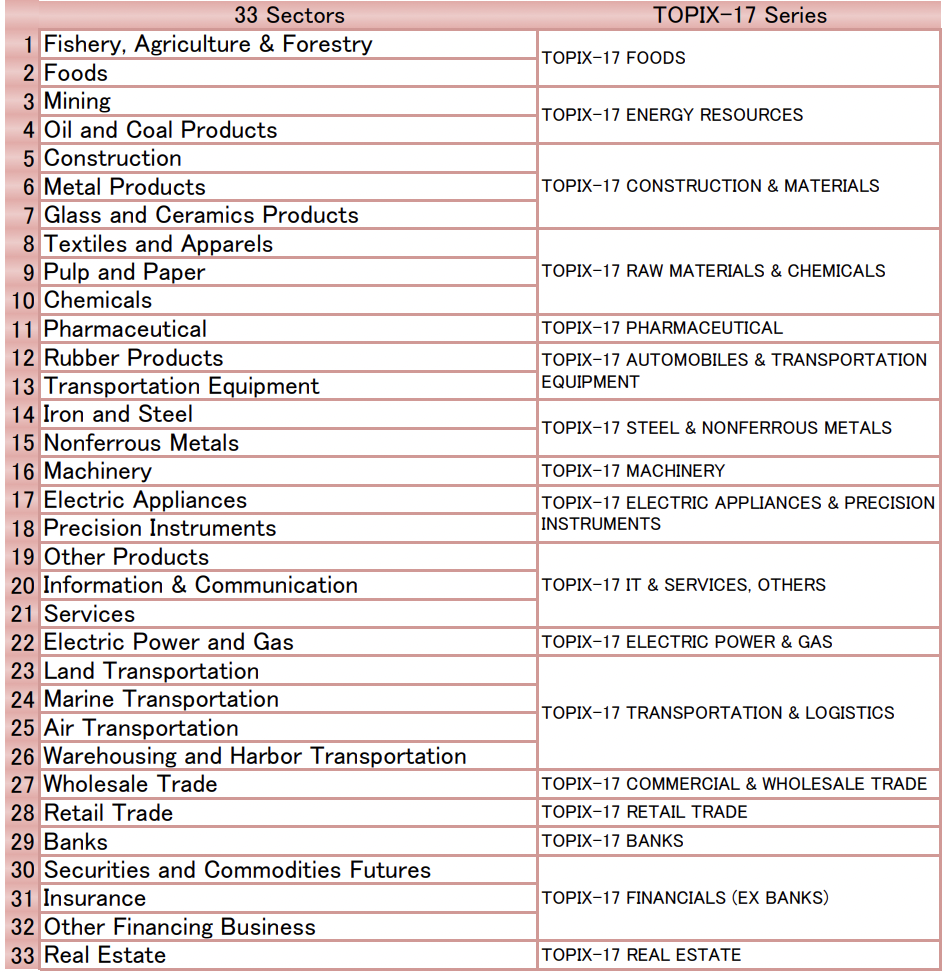

#### 1.2.1: Largest Market Sectors by Market Capitalization

As mentioned earlier, our dataset contains two sector classifications for companies (one with 17 unique sectors, and one with 33). We will first determine the size of each sector in the 17 sector classification system (quantifying the size of each sector by the cumulative market capitalization of the companies that belong to it).

In [10]:
market_cap_grouped = stock_list_df.groupby(by='17SectorName').sum().reset_index()[['17SectorName', 'MarketCapitalization']]
market_cap_grouped = market_cap_grouped[market_cap_grouped['MarketCapitalization'] > 0].sort_values(by='MarketCapitalization',ascending=False).reset_index()
market_cap_grouped['17SectorName'] = market_cap_grouped['17SectorName'].apply(lambda x: "Other" if x == "-" else x)

<ipython-input-10-944146b5733d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  market_cap_grouped = stock_list_df.groupby(by='17SectorName').sum().reset_index()[['17SectorName', 'MarketCapitalization']]


<Figure size 3000x3000 with 0 Axes>

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


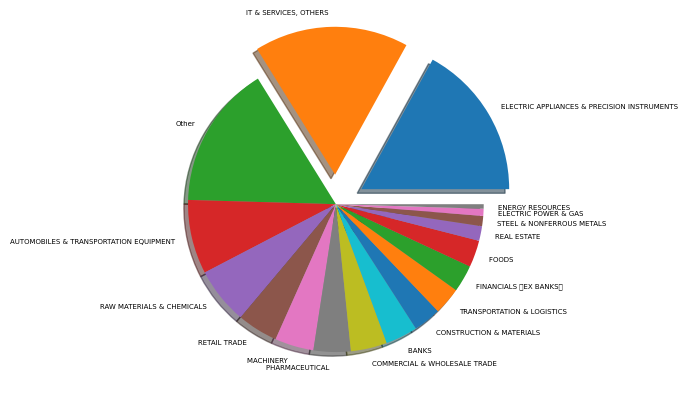

In [11]:
# Attribution: https://stackoverflow.com/questions/7082345/how-to-set-the-labels-size-on-a-pie-chart-in-python

labels = market_cap_grouped['17SectorName']
sizes = market_cap_grouped['MarketCapitalization']

explode = (0.2,0.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
plt.figure(figsize=(30,30))
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, shadow=True, textprops ={'fontsize' : 5})
plt.show()

We clearly see that IT & Services and Electric Appliances are by far the two largest sectors in terms of the cumulative market capitalization of their constituent companies. 

Now, let us try to determine the size of the sectors in the 33 sector classification.

In [12]:
market_cap_grouped_33 = stock_list_df.groupby(by='33SectorName').sum().reset_index()[['33SectorName', 'MarketCapitalization']]
market_cap_grouped_33 = market_cap_grouped_33[market_cap_grouped_33['MarketCapitalization'] > 0].sort_values(by='MarketCapitalization',ascending=False).reset_index()
market_cap_grouped_33['33SectorName'] = market_cap_grouped_33['33SectorName'].apply(lambda x: "Other" if x == "-" else x)

<ipython-input-12-4050933afeb1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  market_cap_grouped_33 = stock_list_df.groupby(by='33SectorName').sum().reset_index()[['33SectorName', 'MarketCapitalization']]


<Figure size 3000x3000 with 0 Axes>

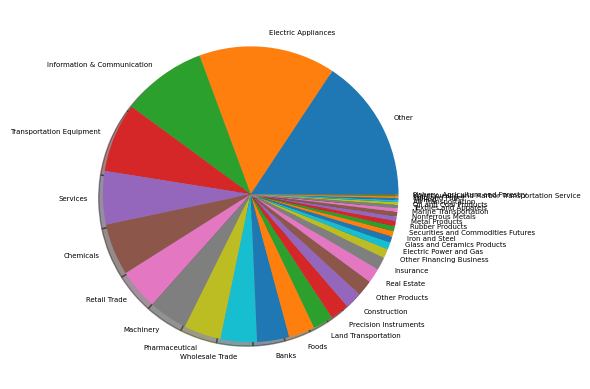

In [13]:
labels = market_cap_grouped_33['33SectorName']
sizes = market_cap_grouped_33['MarketCapitalization']

plt.figure(figsize=(30,30))
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, shadow=True, textprops ={'fontsize' : 5})
plt.show()

Woah! This pie chart is far too crowded for us to determine anything useful. Therefore, to help with interpretability, we will confine our analysis to the 17 sector classification in our subsequent data modeling. 

####1.2.2: Largest Companies in our Dataset by Market Capitalization

We continue our data analysis by determining the 25 largest companies in our dataset by market capitalization. 

In [14]:
largest_companies = stock_list_df.sort_values(by='MarketCapitalization',ascending=False)
largest_companies = largest_companies[largest_companies['Section/Products'] != 'ETFs/ ETNs']
largest_companies = largest_companies.head(25)

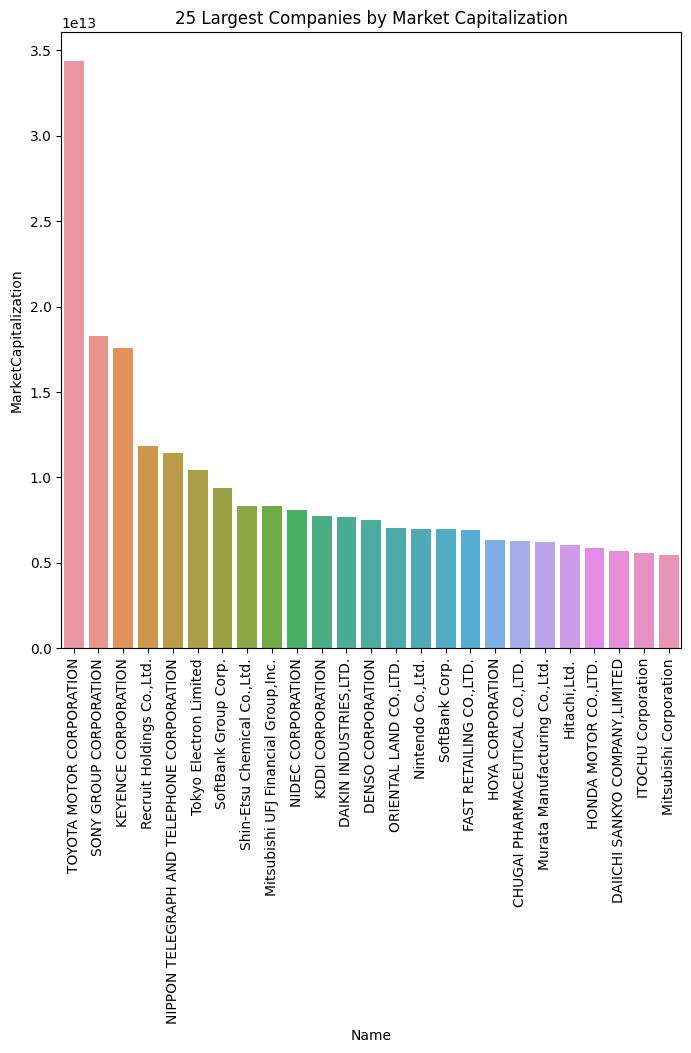

In [15]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=largest_companies, x='Name', y='MarketCapitalization')
plt.xticks(rotation=90)
plt.title('25 Largest Companies by Market Capitalization')
plt.show()

#### 1.2.3: Largest Companies in Each Sector by Market Capitalization

We will now determine the market capitalization of the largest companies in each of the 33 sectors (we use the 33 sector classification since a bar chart allows us to visualize 33 different companies relatively easily). 

In [16]:
largest_sector_companies = stock_list_df[stock_list_df['Section/Products'] != 'ETFs/ ETNs']
largest_sector_companies =  largest_sector_companies.groupby(by='33SectorName').max().reset_index()[['33SectorName', 'MarketCapitalization']]
largest_sector_companies = largest_sector_companies.sort_values(by='MarketCapitalization',ascending=False)
largest_sector_companies = largest_sector_companies.merge(stock_list_df[['Name', 'MarketCapitalization']], how='left', on='MarketCapitalization')

<ipython-input-16-50a116ea9da6>:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  largest_sector_companies =  largest_sector_companies.groupby(by='33SectorName').max().reset_index()[['33SectorName', 'MarketCapitalization']]


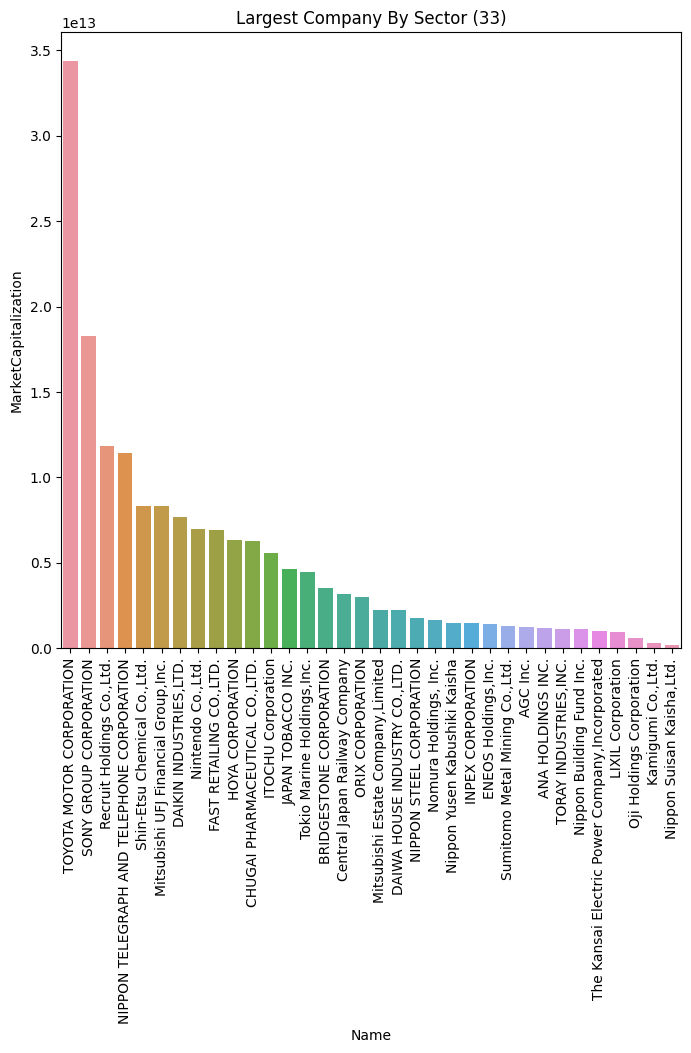

In [17]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=largest_sector_companies, x='Name', y='MarketCapitalization')
plt.xticks(rotation=90)
plt.title('Largest Company By Sector (33)')
plt.show()

We will now consider the relative sizes of the companies in each sector using a boxplot. To ensure our visualization is not too crowded (as the pie chart above was), we will use the 17 sector classification.

<ipython-input-18-931ccda2e5b5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sorted_list_df = sorted_list_df[stock_list_df['17SectorName'] != '-']
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


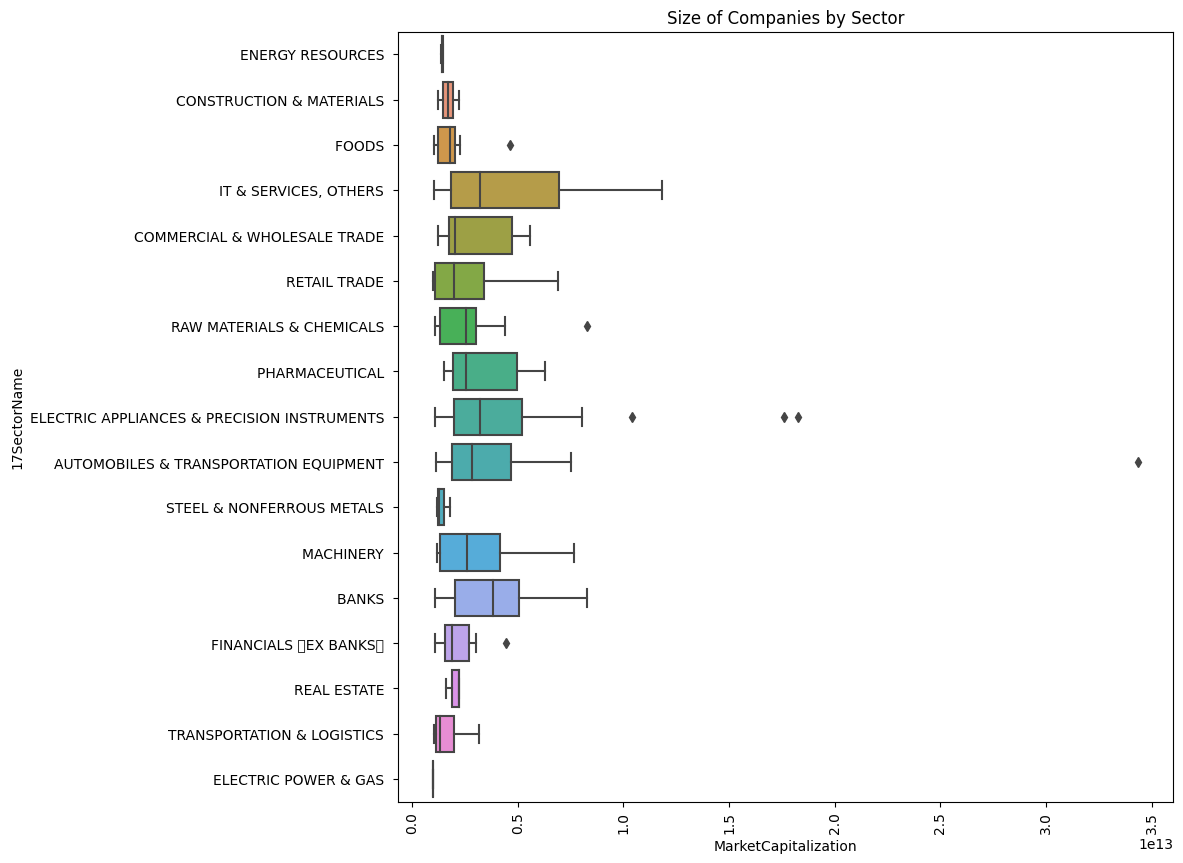

In [18]:
sorted_list_df = stock_list_df[stock_list_df['MarketCapitalization'] > 1000000000000]
sorted_list_df = sorted_list_df[stock_list_df['17SectorName'] != '-']

plt.figure(figsize=(10,10))
ax = sns.boxplot(data=sorted_list_df, x='MarketCapitalization', y='17SectorName')
plt.xticks(rotation=90)
plt.title('Size of Companies by Sector')
plt.show()

#### 1.2.4: Ranking Companies by Performance

We will now determine the best and worst performing companies over the span of time for which their data appears in our dataset, saving the 50 best and worst performers into the best_performers and worst_performers dataframes respectively. 

In [19]:
earliest_dates = main_stocks_with_names[['Name','Date']].groupby(by='Name').min().reset_index() # earliest dates with data
latest_dates = main_stocks_with_names[['Name','Date']].groupby(by='Name').max().reset_index() # latest dates with data

opening_prices = earliest_dates.merge(main_stocks_with_names,how='left',on=['Name','Date'])[['Name','Date','Open']].dropna()
closing_prices = latest_dates.merge(main_stocks_with_names,how='left',on=['Name','Date'])[['Name','Date','Close_x']].dropna()

prices = opening_prices.merge(closing_prices,how='inner',on='Name')[['Name','Open','Close_x']]

prices['% Change'] = 100 * (prices['Close_x'] - prices['Open']) / prices['Open']

best_performers = prices.sort_values(by='% Change',ascending=False).head(50)
worst_performers = prices.sort_values(by='% Change').head(50)

We will now graph the 50 best performing companies.....

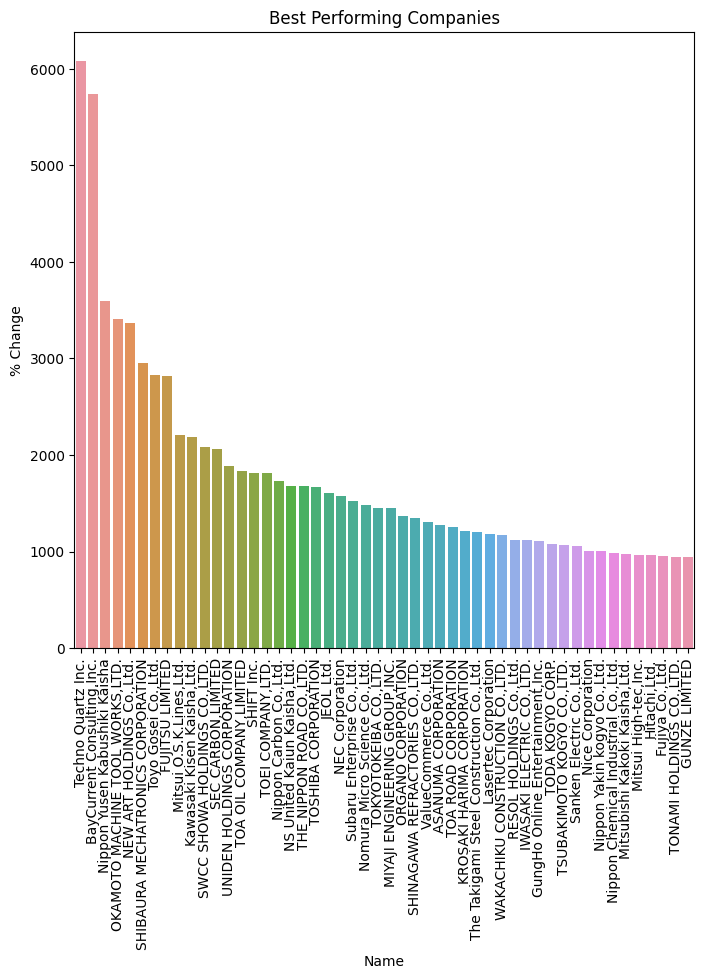

In [20]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=best_performers, x='Name', y='% Change')
plt.xticks(rotation=90)
plt.title('Best Performing Companies')
plt.show()

..... and the 50 worst performing companies. 

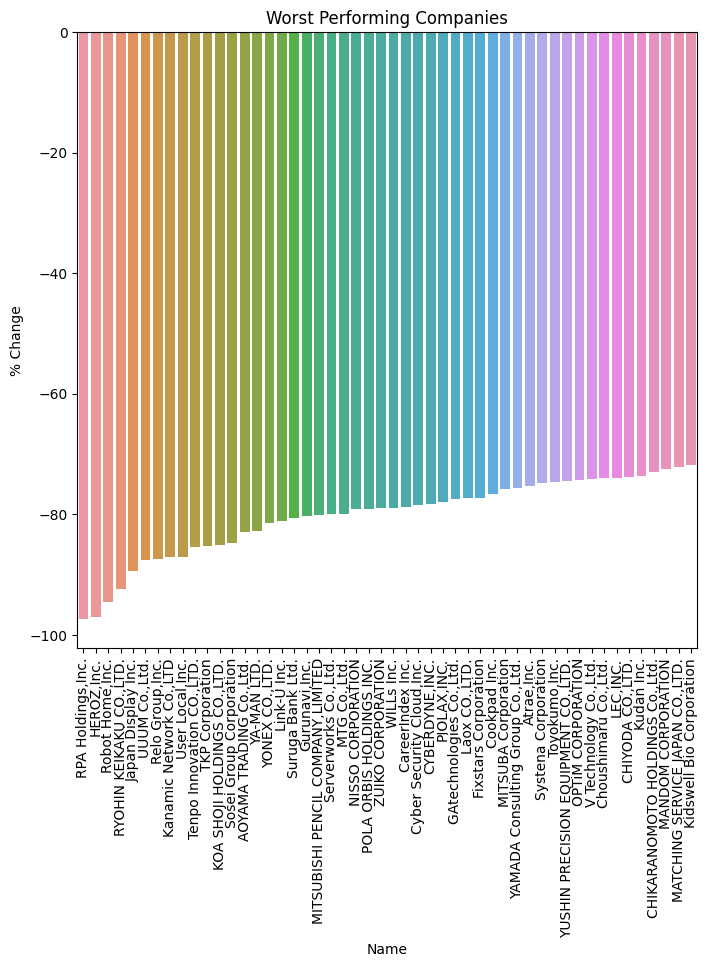

In [21]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=worst_performers, x='Name', y='% Change')
plt.xticks(rotation=90)
plt.title('Worst Performing Companies')
plt.show()

Of the ~2000 companies we have data for, we will now consider the best and worst performers among the 100 largest companies (which we define as the 100 largest companies by market capitalization, using the latest market capitalization figures we have).

We will first obtain the most recent market capitalization data we have for each company.

In [22]:
market_caps = latest_dates.merge(main_stocks_with_names,how='left',on=['Name','Date'])[['Name','Date','MarketCapitalization']].dropna()
largest_companies = market_caps.sort_values(by='MarketCapitalization',ascending=False).head(100)

In [23]:
performance = largest_companies.merge(prices,on='Name',how='left')[['Name','% Change']]

best_large_performers = performance.sort_values(by='% Change',ascending=False).head(20)
worst_large_performers = performance.sort_values(by='% Change').head(20)

We can now plot the best performing large companies......

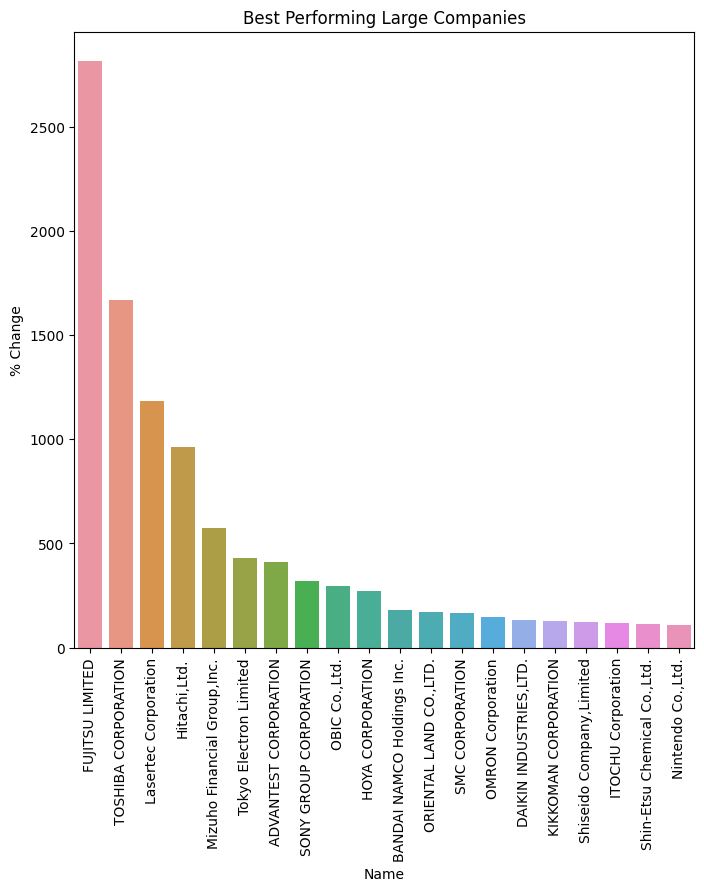

In [24]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=best_large_performers, x='Name', y='% Change')
plt.xticks(rotation=90)
plt.title('Best Performing Large Companies')
plt.show()

......and the worst performing large companies.

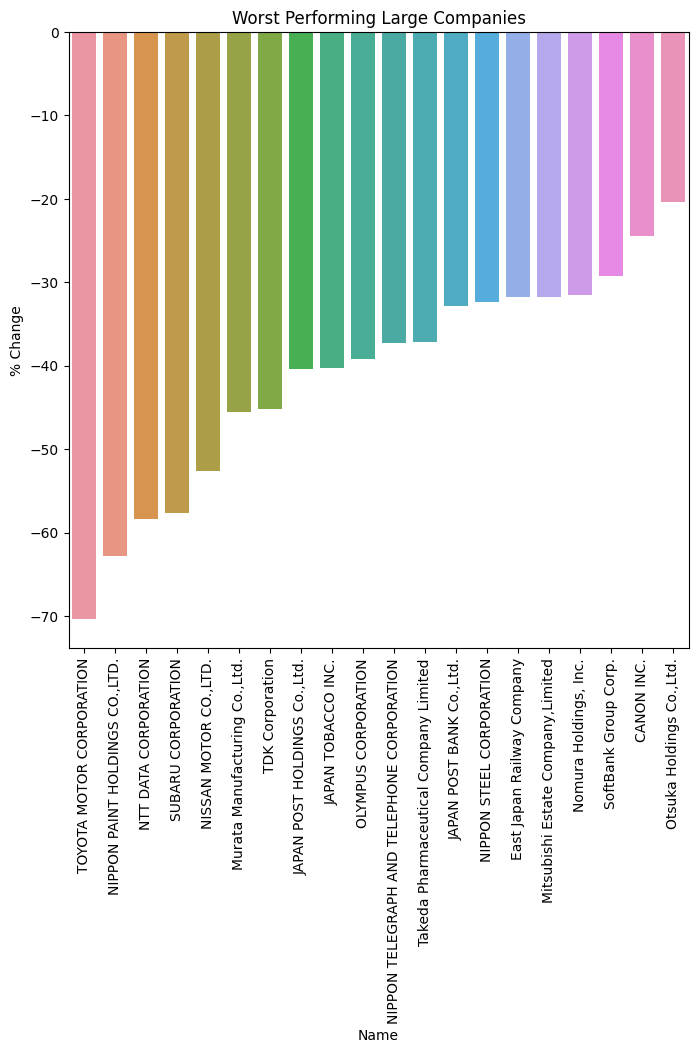

In [25]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=worst_large_performers, x='Name', y='% Change')
plt.xticks(rotation=90)
plt.title('Worst Performing Large Companies')
plt.show()

From the graphs above, we observe that there is seemingly lower volatility in the performance of the larger companies. 

We'll explore if our hunch is right by determining the correlation between a company's market capitalization and the magnitude of the percent change observed. We'll begin by setting up a correlation matrix to quantify the correlation between thse two values. 

In [26]:
corr_df = prices.merge(market_caps,how='inner',on='Name')
corr_df['Absolute % Change'] = corr_df['% Change'].apply(lambda x : abs(x))
corr = corr_df[['Absolute % Change','MarketCapitalization']]
corr_mat = corr.corr()

We'll now represent this correlation matrix as a heatmap. 

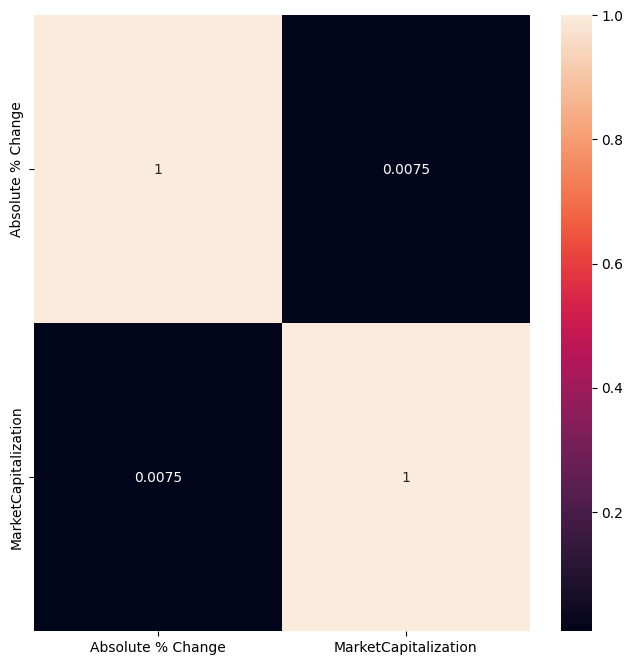

In [27]:
plt.figure(figsize=(8,8))
ax = sns.heatmap(corr_mat,annot=True)
plt.show()

It seems (somewhat counterintuitively) that there is very little correlation between a company's market capitalization and its volatility (represented by the absolute % change), in our dataset. 

##**Part 2: Regression Modeling**
We'll now attempt to develop multiple regression models (and identify an optimal one) to predict our target value: the target change ratio $r_c$, which we defined earlier as follows: $r_c = \frac{(C_{k+2} - C_{k+1})}{C_{k+1}}$.

### 2.0: Data Preprocessing

In [28]:
mn = main_stocks_with_names.groupby("SecuritiesCode").mean()
target = mn['Target']
features = mn.drop('Target',axis=1)

<ipython-input-28-93d2befa1778>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mn = main_stocks_with_names.groupby("SecuritiesCode").mean()


We will first split our data into training data and validation data (in order to test how well any model we train on the training data does), setting aside 25% of the data as validation data to test any models we develop. 

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features,target,test_size = 0.25, random_state = 42)

####2.0.1 Feature Selection
We begin the process by first determining the most relevant features in our data, which we will do using Principle Component Analysis (PCA).

#####Imports

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

##### PCA 

(The code for this section was taken from Homework #4) 
We will now do a PCA to determine the ideal number of components to use. 

In [31]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

pca = PCA(n_components = 13)
pca_X_train = pca.fit_transform(scaled_X_train)
pca_X_test = pca.transform(scaled_X_test)

explained_variance_ratios = pca.explained_variance_ratio_
components = np.cumsum(pca.explained_variance_ratio_)

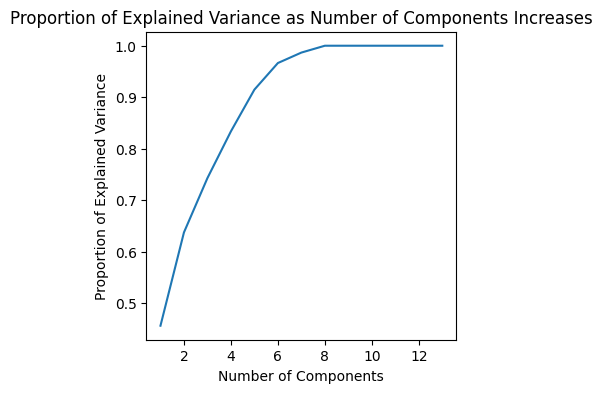

In [32]:
plt.figure(figsize=(4,4))
plt.plot(np.arange(1,14),components)

# From HW 4 
plt.title('Proportion of Explained Variance as Number of Components Increases')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Explained Variance')
plt.show()

Based on this elbow plot, we see that, out of our 13 components, over 90% of the variance is explained using 6 components. Thus, we will use 6 components in our PCA. 

In [33]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(scaled_X_train)
X_test_pca = pca.transform(scaled_X_test)

###2.1: Regression Model Selection

We will now try a variety of models and determine their accuracy on our validation data (y_test). We will split our models into two broad classes (Regression Models and Neural Networks).

For each Regression Model, we will quantify its performance by determining its normalized RMSE and R2 scores (we use normalized RMSE because our target value is quite small, and we want to more meaningfully compare the error in different models). 

#### 2.1.1: LinearRegression

In [34]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

In [35]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
linreg_rmse_score = mean_squared_error(y_test,y_pred,squared=False) / (y_test.max() - y_test.min())
linreg_r2 = r2_score(y_test,y_pred)

In [36]:
print(linreg_rmse_score)
print(linreg_r2)

0.06960573413269647
0.39613005019997793


We see from this baseline linear regression that we obtain an RMSE of ~0.070 and an R2 of ~0.396 using a simple Linear Regression model. 

####2.1.2: LinearRegression (w/ PCA)

In [37]:
reg_pca = LinearRegression().fit(X_train_pca, y_train)
y_pred = reg_pca.predict(X_test_pca)
pca_rmse_score = mean_squared_error(y_test,y_pred,squared=False)
pca_r2 = r2_score(y_test,y_pred)

In [38]:
print(pca_rmse_score)
print(pca_r2)

0.0007007829586010796
0.05844646398293174


We see that PCA does not seem to increase model performance, as we obtain an RMSE of ~0.001 and an R2 of ~0.058 using a Linear Regression model with PCA. 

####2.1.3: RandomForestRegressor

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
r_rmse_train_accuracies = []
r_rmse_test_accuracies = []
r_r2_train_accuracies = []
r_r2_test_accuracies = []

for i in range(1,51):
  rf = RandomForestRegressor(random_state = 42, n_estimators = 25, max_depth = i)
  rf.fit(X_train, y_train)

  y_train_pred = rf.predict(X_train)
  y_test_pred = rf.predict(X_test)
  
  score_train = mean_squared_error(y_train_pred,y_train,squared=False)
  score_train = score_train / (y_train.max() - y_train.min())
  
  score_test = mean_squared_error(y_test_pred,y_test,squared=False)
  score_test = score_test / (y_test.max() - y_test.min())

  r_rmse_train_accuracies.append(score_train)
  r_rmse_test_accuracies.append(score_test)
  
  r2_train = r2_score(y_train,y_train_pred)
  r2_test = r2_score(y_test,y_test_pred)
  
  r_r2_train_accuracies.append(r2_train)
  r_r2_test_accuracies.append(r2_test)

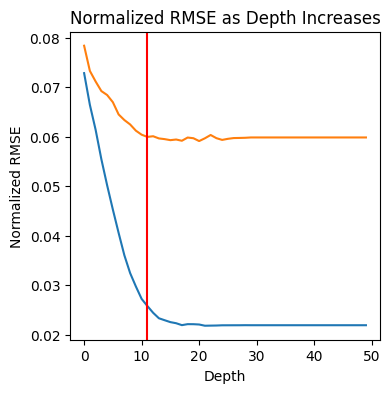

In [41]:
plt.figure(figsize=(4,4))
ax1 = sns.lineplot(data=r_rmse_train_accuracies)
ax2 = sns.lineplot(data=r_rmse_test_accuracies)
plt.xticks()
plt.xlabel('Depth')
plt.ylabel('Normalized RMSE')
plt.axvline(x=11,color='r')
plt.title('Normalized RMSE as Depth Increases')
plt.show()

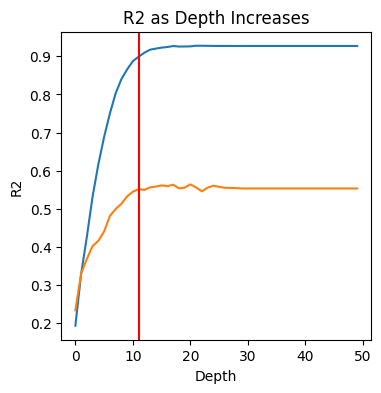

In [42]:
plt.figure(figsize=(4,4))
ax1 = sns.lineplot(data=r_r2_train_accuracies)
ax2 = sns.lineplot(data=r_r2_test_accuracies)
plt.xticks()
plt.xlabel('Depth')
plt.ylabel('R2')
plt.axvline(x=11,color='r')
plt.title('R2 as Depth Increases')
plt.show()

From these graphs, we see that, around 11 iterations (the red line in each graph above), the model's performance on the test data is most optimal, because, up to this point, the normalized RMSE is decreasing and R2 is increasing, and after this point, the RMSE begins to slightly increase, while the R2 flatlines. 

In [43]:
rf = RandomForestRegressor(random_state = 42, n_estimators = 25, max_depth = 11)
rf.fit(X_train, y_train)
y_test_pred = rf.predict(X_test)
rmse_score_test = mean_squared_error(y_test_pred,y_test,squared=False)
norm_rmse_score_test = rmse_score_test / (y_test.max() - y_test.min())
r2_test = r2_score(y_test,y_test_pred)

In [44]:
print(norm_rmse_score_test)
print(r2_test)

0.06043436901437933
0.5447799669959025


We see that we obtain an RMSE of ~0.060 and an R2 of ~0.545 using a RandomForest Regressor

#### 2.1.4: ElasticNet

In [45]:
from sklearn.linear_model import ElasticNet

In [46]:
e_rmse_train_accuracies = []
e_rmse_test_accuracies = []
e_r2_train_accuracies = []
e_r2_test_accuracies = []

for i in range(1,101):
  en = ElasticNet(alpha=1.0, l1_ratio=i/100)
  en.fit(X_train, y_train)

  y_train_pred = en.predict(X_train)
  y_test_pred = en.predict(X_test)
  
  score_train = mean_squared_error(y_train_pred,y_train,squared=False)
  score_train = score_train / (y_train.max() - y_train.min())
  
  score_test = mean_squared_error(y_test_pred,y_test,squared=False)
  score_test = score_test / (y_test.max() - y_test.min())

  e_rmse_train_accuracies.append(score_train)
  e_rmse_test_accuracies.append(score_test)
  
  r2_train = r2_score(y_train,y_train_pred)
  r2_test = r2_score(y_test,y_test_pred)
  
  e_r2_train_accuracies.append(r2_train)
  e_r2_test_accuracies.append(r2_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.201e-04, tolerance: 9.088e-08
  model = cd_fast.enet_coordinate_descent(


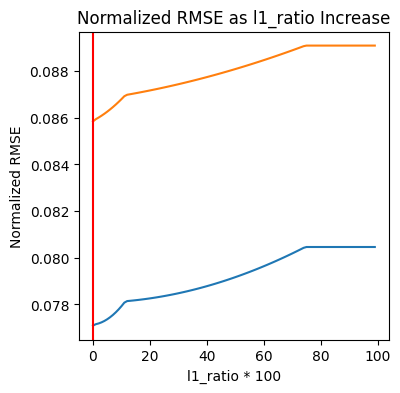

In [47]:
plt.figure(figsize=(4,4))
ax1 = sns.lineplot(data=e_rmse_train_accuracies)
ax2 = sns.lineplot(data=e_rmse_test_accuracies)
plt.xticks()
plt.xlabel('l1_ratio * 100')
plt.ylabel('Normalized RMSE')
plt.axvline(x=0,color='r')
plt.title('Normalized RMSE as l1_ratio Increase')
plt.show()

(Note: Pyplot was being a bit finicky with axis labels here, so we decided to show the l1_ratio multiplied by 100 to ensure the axes labels matched up)

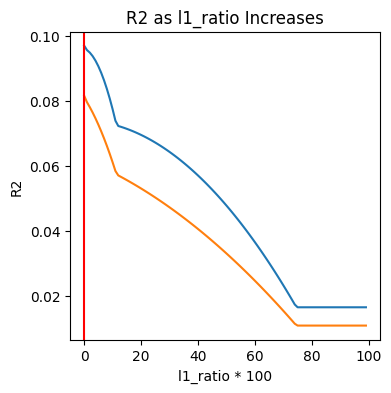

In [48]:
plt.figure(figsize=(4,4))
ax1 = sns.lineplot(data=e_r2_train_accuracies)
ax2 = sns.lineplot(data=e_r2_test_accuracies)
plt.xticks()
plt.xlabel('l1_ratio * 100')
plt.ylabel('R2')
plt.axvline(x=0,color='r')
plt.title('R2 as l1_ratio Increases')
plt.show()

We notice that the Normalized RMSE is lowest, and the R2 is highest, when the l1_ratio is 0, and thus, we choose 0 as the value of our l1_ratio. 

In [49]:
en = ElasticNet(alpha=1.0, l1_ratio=0)
en.fit(X_train, y_train)
y_test_pred = en.predict(X_test)
rmse_score_test = mean_squared_error(y_test_pred,y_test,squared=False)
norm_rmse_score_test = rmse_score_test / (y_test.max() - y_test.min())
r2_test = r2_score(y_test,y_test_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.808e-04, tolerance: 9.088e-08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [50]:
print(norm_rmse_score_test)
print(r2_test)

0.08359887167245529
0.12892767987649467


Using an ElasticNet Regression (practically a RidgeRegression, since we wound up setting the l1_ratio to be 0), we obtain a normalized RMSE of ~0.084 and an R2 of ~0.129

#### 2.1.5: HistGradientBoostingRegressor

In [51]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [52]:
h_rmse_train_accuracies = []
h_rmse_test_accuracies = []
h_r2_train_accuracies = []
h_r2_test_accuracies = []
for i in range(1,101):
  clf = HistGradientBoostingRegressor(random_state = 42,max_iter=i).fit(X_train,y_train)
  
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  
  score_train = mean_squared_error(y_train_pred,y_train,squared=False)
  score_train = score_train / (y_train.max() - y_train.min())
  
  score_test = mean_squared_error(y_test_pred,y_test,squared=False)
  score_test = score_test / (y_test.max() - y_test.min())

  h_rmse_train_accuracies.append(score_train)
  h_rmse_test_accuracies.append(score_test)
  
  r2_train = r2_score(y_train,y_train_pred)
  r2_test = r2_score(y_test,y_test_pred)
  
  h_r2_train_accuracies.append(r2_train)
  h_r2_test_accuracies.append(r2_test)

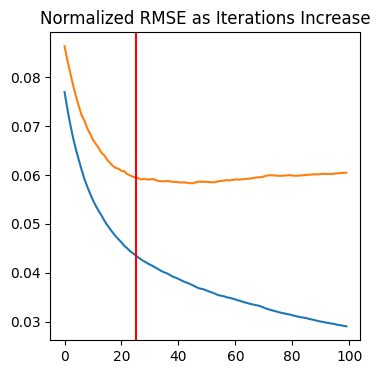

In [53]:
plt.figure(figsize=(4,4))
ax1 = sns.lineplot(data=h_rmse_train_accuracies)
ax2 = sns.lineplot(data=h_rmse_test_accuracies)
plt.xticks()
plt.axvline(x=25,color='r')
plt.title('Normalized RMSE as Iterations Increase')
plt.show()

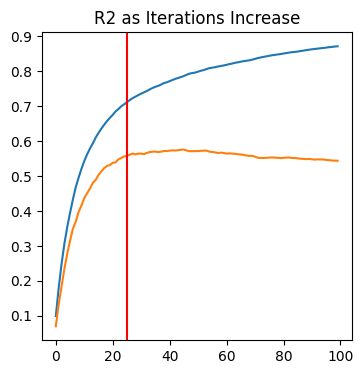

In [54]:
plt.figure(figsize=(4,4))
ax1 = sns.lineplot(data=h_r2_train_accuracies)
ax2 = sns.lineplot(data=h_r2_test_accuracies)
plt.xticks()
plt.axvline(x=25,color='r')
plt.title('R2 as Iterations Increase')
plt.show()

From these graphs, we see that, around 25 iterations (the red line in each graph above), the model's performance on the test data is most optimal, because, up to this point, the normalized RMSE is decreasing and R2 is increasing, and after this point, the RMSE begins to slightly increase, while the R2 flatlines. 

In [55]:
clf = HistGradientBoostingRegressor(random_state = 42,max_iter=25).fit(X_train,y_train)
rmse_score_test = mean_squared_error(y_test_pred,y_test,squared=False)
norm_rmse_score_test = rmse_score_test / (y_test.max() - y_test.min())
r2_test = r2_score(y_test,y_test_pred)

In [56]:
print(norm_rmse_score_test)
print(r2_test)

0.06046965493970853
0.5442482315056276


We see that we obtain an RMSE of ~0.061 and an R2 of ~0.544 using a Histogram-Based Gradient Boosting Classifier.

#### Model Comparison

(source code for table @ https://www.markdownguide.org/extended-syntax/#escaping-pipe-characters-in-tables)

| Model      | Normalized RMSE | R2    |
| :---        |    :----:   |          ---: |
| Linear Regression      | 0.06960573413269647 | 0.39613005019997793 |
| Linear Regression (w/ PCA)  | 0.0007007829586010795 | 0.05844646398293196     |
| RandomForestRegressor      | 0.06043436901437933       | 0.5447799669959025   |
| ElasticNet   | 0.08359887167245529 | 0.12892767987649467 
| HistGradientBoostingRegressor      | 0.06046965493970853| 0.5442482315056276   |

We see that the RandomForestRegressor and HistGradientBoostingRegressor are the best performing models, showing both a relatively low normalized RMSE and a high R2 score. While the Linear Regression with PCA had the lowest RMSE of any model we tested, it had an extremely low R2 score. As such, the linear regression model has extremely low correlation and cannot be likely trusted for prediction. RandomForestRegressor and HistGradientBoostingRegressor are both ensemble methods, suggesting that for this particular problem we can rely on ensemble methods. 

## **Part 3: Deep Learning Networks**

We'll now move out of the model space of regressors and look at neural networks. We will use a Recurrent Neural Network. 

###3.1: Recurrent Neural Network


 We'll first load our device (code taken from HW #5). 

 A recurrent neural network (RNN) is an artificial neural network. It uses a feedback loop to pass information from one step of the sequence to the next, allowing it to maintain a sort of memory of past inputs. RNNs can be trained using techniques like backpropagation, but have challenges with the vanishing gradient problem.

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

This code defines a recurrent neural network (RNN) model using the PyTorch library in Python. 
The RNNNet class constructor takes in three arguments: input_size, hidden_size, and output_size. These parameters define the size of the input layer, the hidden layer, and the output layer, respectively. The constructor then calls the constructor of the nn.Module superclass using the super() function to initialize the inherited properties.

The hidden_size property is set to the size of the hidden layer, which will be used to define the RNN layer. The RNN layer is defined using the nn.RNN class, which takes in the input_size and hidden_size as arguments, and sets batch_first to True. The batch_first parameter indicates that the input tensor has the batch size as the first dimension.

Two fully connected (FC) layers are defined to map the output of the RNN layer to the output_size. The first FC layer is defined using the nn.Linear class, which takes in the hidden_size as the input size, and 64 as the output size. The second FC layer takes in 64 as the input size, and the output_size as the output size.

Two activation functions are defined: a ReLU activation function, which is used after the first FC layer, and a dropout layer with a probability of 0.4, which is used after both the RNN and first FC layer. The dropout layer helps to prevent overfitting by randomly dropping out some neurons during training.

The forward() method takes in an input tensor x, and initializes a hidden state h0 using the torch.zeros() function, with the batch size as the second dimension. The input tensor x is then passed to the RNN layer, along with the hidden state h0. The output of the RNN layer is stored in the out variable.

The out tensor is then passed through the dropout layer, and the first FC layer. The ReLU activation function is applied to the output of the first FC layer, and the result is passed through the dropout layer again. Finally, the output of the second FC layer is returned as the output of the model.







We'll now define the architecture for our Recurrent Neural Network.

In [58]:
class RNNet(nn.Module):
   def __init__(self, input_size, hidden_size, output_size):
       super(RNNet, self).__init__()
       self.hidden_size = hidden_size
       self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
       self.fc1 = nn.Linear(hidden_size, 64)
       self.fc2 = nn.Linear(64, output_size)
       self.relu = nn.ReLU()
       self.dropout = nn.Dropout(p=0.4)
      
   def forward(self, x):
       h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
      
       out, _ = self.rnn(x, h0)
       out = self.dropout(out)
       out = self.fc1(out[:, -1, :])
       out = self.relu(out)
       out = self.dropout(out)
       out = self.fc2(out)
       return out

This code prepares the data for training and testing an RNN model using PyTorch.
The input_size is set to the number of columns in the X_train dataset, which represents the input features for the model. The hidden_size is set to 64, and output_size is set to 1, which represents the output of the model.
The learning_rate is set to 0.0009, and the number of epochs is set to 60, which are hyperparameters that control the training process.
An instance of the RNNNet class is created, and the Mean Squared Error (MSE) loss function and Adam optimizer are defined. The Adam optimizer is used to update the model parameters during training.
The X_train and y_train datasets are converted to PyTorch tensors and reshaped to have the batch size as the first dimension using the .reshape() method. This is necessary for training an RNN model in PyTorch, as the RNN layer expects input data to have the batch size as the first dimension.
Similarly, the X_test and y_test datasets are also converted to PyTorch tensors and reshaped. These tensors will be used to evaluate the performance of the trained model on test data.






In [59]:

input_size = len(X_train.columns)
hidden_size = 64
output_size = 1
learning_rate = 0.009
num_epochs = 60

model = RNNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


X1_train = torch.tensor(X_train.values.reshape(-1, 1, input_size), dtype=torch.float32)
Y1_train = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X1_test = torch.tensor(X_test.values.reshape(-1, 1, input_size), dtype=torch.float32)
Y1_test = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)


This code is the main training loop for the RNN model.
For each epoch, the model takes the X1_train tensor as input and generates output predictions using the forward() method. The criterion (MSE loss) is then used to compute the loss between the predicted outputs and the true labels (Y1_train).
The optimizer's gradients are then set to zero using optimizer.zero_grad(), and the loss is backpropagated through the network using loss.backward(). The optimizer is then updated with optimizer.step().
The loss is then computed as the square root of the MSE loss (i.e., the root mean squared error or RMSE), and the loss is printed for each epoch.
The loop runs for num_epochs, which is set to 60 in this code. By the end of training, the model's weights should be optimized to minimize the training loss, and the model can be used to make predictions on new data.




In [60]:
loss_vals = []
for epoch in range(num_epochs):
    
    outputs = model(X1_train)

    loss = criterion(outputs, Y1_train)
   
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss = torch.sqrt(loss)

    loss_vals.append(loss.item())
    print('Epoch [{}/{}], RMSE Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/60], RMSE Loss: 0.5001
Epoch [2/60], RMSE Loss: 1.2104
Epoch [3/60], RMSE Loss: 0.5270
Epoch [4/60], RMSE Loss: 0.2851
Epoch [5/60], RMSE Loss: 0.4626
Epoch [6/60], RMSE Loss: 0.4879
Epoch [7/60], RMSE Loss: 0.4027
Epoch [8/60], RMSE Loss: 0.3067
Epoch [9/60], RMSE Loss: 0.2279
Epoch [10/60], RMSE Loss: 0.1686
Epoch [11/60], RMSE Loss: 0.1278
Epoch [12/60], RMSE Loss: 0.1025
Epoch [13/60], RMSE Loss: 0.0863
Epoch [14/60], RMSE Loss: 0.0760
Epoch [15/60], RMSE Loss: 0.0692
Epoch [16/60], RMSE Loss: 0.0663
Epoch [17/60], RMSE Loss: 0.0620
Epoch [18/60], RMSE Loss: 0.0611
Epoch [19/60], RMSE Loss: 0.0591
Epoch [20/60], RMSE Loss: 0.0572
Epoch [21/60], RMSE Loss: 0.0565
Epoch [22/60], RMSE Loss: 0.0567
Epoch [23/60], RMSE Loss: 0.0558
Epoch [24/60], RMSE Loss: 0.0539
Epoch [25/60], RMSE Loss: 0.0547
Epoch [26/60], RMSE Loss: 0.0532
Epoch [27/60], RMSE Loss: 0.0528
Epoch [28/60], RMSE Loss: 0.0513
Epoch [29/60], RMSE Loss: 0.0518
Epoch [30/60], RMSE Loss: 0.0490
Epoch [31/60], RMSE

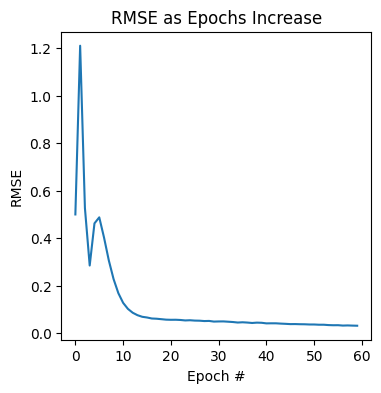

In [61]:
plt.figure(figsize=(4,4))
ax1 = sns.lineplot(data=loss_vals)
plt.xticks()
plt.xlabel('Epoch #')
plt.ylabel('RMSE')
plt.title('RMSE as Epochs Increase')
plt.show()

This code evaluates the performance of the trained RNN model on the test data using PyTorch's no_grad() context manager.
First, the model's predictions on the test data are computed by passing the X1_test tensor through the trained model using model(X1_test).
Then, the MSE loss between the predicted outputs and the true labels (Y1_test) is computed using the criterion (MSE loss) function.
Finally, the RMSE value of the MSE loss is computed and printed as the performance metric for the model on the test set. This metric gives an estimate of the average error in the model's predictions on unseen data. A lower RMSE value indicates better model performance.



In [62]:

with torch.no_grad():
    predicted = model(X1_test)
    mse = criterion(predicted, Y1_test)
    rmse = torch.sqrt(mse) 
    print('RMSE on the test set: {:.4f}'.format(rmse))

RMSE on the test set: 0.0304


We see that our RNN model has an RMSE of 0.0304 on the test dataset, which seems to suggest that it performs well on on our dataset. 

## Part 4: Closing Thoughts

Overall, our goal with this project was to predict target closing price from stock data for the Japanese Stock Market. We used several regression models to make our predictions, after cleaning our data. Through extensive cleaning, we made sure everything was formatted correctly for our models. We had 13 features for prediction and through use of PCA, we were able to reduce this amount to 6. With the pre-processing and cleaning done, we began work on creating and running our models, making use of graphical analysis and EDA to gain true understanding of the data. Finally, we were able to predict the two best models for prediction, both of which were ensemble methods. Finally, as a finishing touch, we coded a neural network which seemed to perform well in prediction. In essence, we replicated all the steps from our Big Data homeworks to create a final data science project! 


While developing this project, there were definitely some challenges which we faced. First, like every data scientist, we wished that we had more stocks in our data to create more robust models. More importantly, throughout the CIS 5450 programming homeworks, we focused and learned the process on how to create and evaluate predictive models for classification. However, our project was a regression task, which has its own set of predictive parameters and machine and deep learning models. Thus, before proceeding with our model selection process, 

We needed to do quite a bit of research beforehand to determine what metrics would work best with our models, and training these models in practice with our datasets was a more difficult challenge. We also ran into issues during the model selection process (for example, we spent quite a bit of time trying to determine the optimal neural network architecture for the data that we had). However, it was certainly a valuable learning experience, and we are glad that we decided our project on predicting stock returns through regression ML and neural networks. 

In the future, given the sequential nature of our dataset, we are considering testing it with more robust volumes of data on neural network arcitecture that are specfically geared towards time stamp data(LSTMs). We are confident that with ample data and architecture that is more suitable to the task at hand, we can create even more powerful models. 
 
Thanks for reading! We hope that you have enjoyed our project about predicting returns in Japan’s Stock Market. 

	⁃	Divek, Anirudh, Aryan